## 0. Load functions and set parameters

In [1]:
# For the notebook to work you must have m3_learning installed
# pip install m3_learning
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../src')
from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.viz.layout import imagemap, layout_fig, labelfigs
from m3_learning.RHEED.Dataset import RHEED_parameter_dataset
from m3_learning.RHEED.Viz import Viz, set_style_RHEED
from m3_learning.RHEED.Analysis import detect_peaks, analyze_curves, remove_outlier, smooth, fit_exp_function

printing = printer(basepath = '../../Figures/2023_RHEED_PLD_SrTiO3/')
set_style("printing")
random_seed(seed=42)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
%matplotlib inline
seq_colors = ['#00429d','#2e59a8','#4771b2','#5d8abd','#73a2c6','#8abccf','#a5d5d8','#c5eddf','#ffffe0']
bgc1, bgc2 = colors.hex2color(seq_colors[0]), colors.hex2color(seq_colors[5])
color_blue = (44/255,123/255,182/255)
color_orange = (217/255,95/255,2/255)
color_purple = (117/255,112/255,179/255)

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## 1. Examples of Fitted RHEED Intenstity Curve

In [2]:
spot = 'spot_2'
metric = 'img_sum'
camera_freq = 500
fit_settings = {'savgol_window_order': (15, 3), 'pca_component': 10, 'I_diff': 15000, 
                'unify':False, 'bounds':[0.001, 1], 'p_init':[0.1, 0.4, 0.1]}

## 2. Analyze the Decay Curve

### 2.1 Fitting RHEED Intensity with Exponential Function for Intensity Magnitude and Characteristic Time

#### 2.1.1 Treated substrate (step width=0.43±0.04μm) - growth_1 - fitting with sklearn functions

##### (1). Fitting process with visualization of decay curve and fitted data

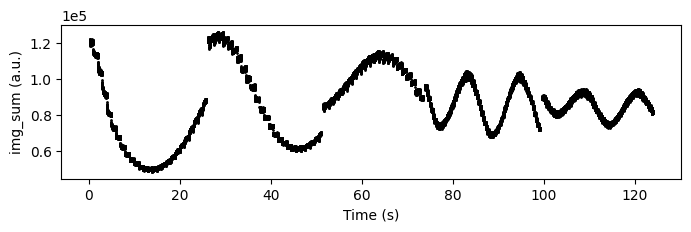

In [3]:
path = 'D:/datasets/RHEED_data/test6_gaussian_fit_parameters_all-04232023.h5'
D1_para = RHEED_parameter_dataset(path, camera_freq=500, sample_name='t0.21')

growth_list = ['growth_1', 'growth_2', 'growth_3', 'growth_4', 'growth_5']
D1_para.viz_RHEED_parameter_trend(growth_list, spot='spot_2', metric_list=['img_sum'], head_tail=(100,300), interval=200)

In [4]:
growth_dict = {'growth_1':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3}
x_all, y_all = D1_para.load_multiple_curves(growth_dict.keys(), spot, metric, x_start=0, interval=0)

parameters_all, x_coor_all, info = analyze_curves(D1_para, growth_dict, spot, metric, interval=0, fit_settings=fit_settings)
[xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info

# define two color regime
x_y1 = x_coor_all[losses_all[:,0]>losses_all[:,1]]
x_y2 = x_coor_all[losses_all[:,0]<losses_all[:,1]]
color_array = Viz.two_color_array(x_coor_all, x_y1, x_y2, bgc1, bgc2, transparency=0.5)
color_array = np.concatenate([np.expand_dims(x_coor_all, 1), color_array], axis=1)


#### (2). Fitted parameters

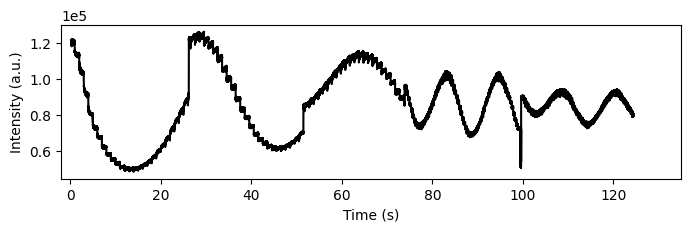

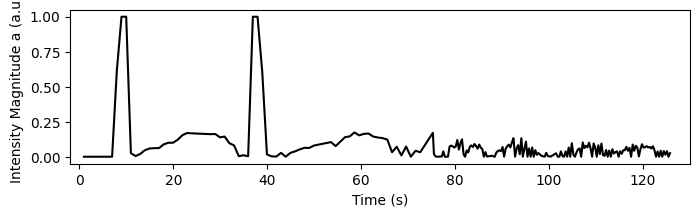

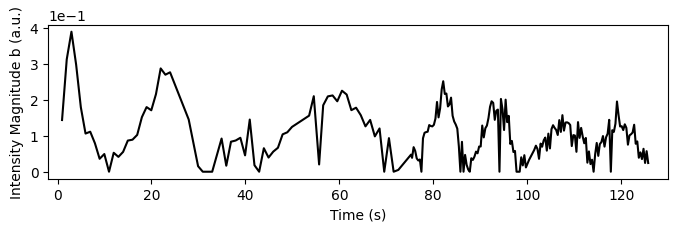

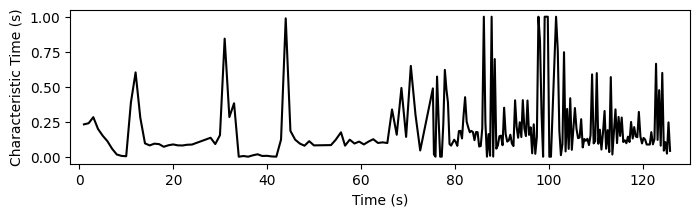

In [5]:
Viz.plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(8, 2), xlim=(-2, 135))
Viz.plot_curve(x_coor_all, parameters_all[:,0], plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude a (a.u.)', 
           yaxis_style='sci', figsize=(8, 2), xlim=(-2, 130))
Viz.plot_curve(x_coor_all, parameters_all[:,1], plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude b (a.u.)', 
           yaxis_style='sci', figsize=(8, 2), xlim=(-2, 130))
Viz.plot_curve(x_coor_all, parameters_all[:,2], plot_type='lineplot', xlabel='Time (s)', ylabel='Characteristic Time (s)', 
           yaxis_style='sci', figsize=(8, 2), xlim=(-2, 130))

#### (3). Because there is hard boundary when characteristic >= 1, so we can assume the characteristic data that >= 0.95 are outliers and remove from plot. And we also process the data with less noise to observe the trend.

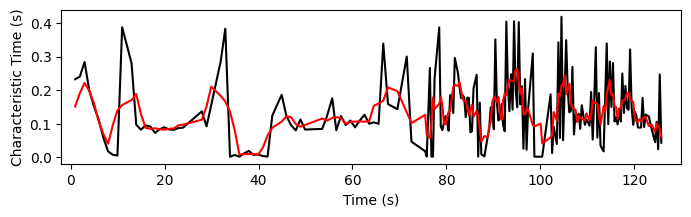

In [6]:
x_coor_all_clean, tau_clean = remove_outlier(x_coor_all, parameters_all[:,2], 0.95)
tau_smooth = smooth(tau_clean, 5)

x_coor_all_clean_sample1 = np.copy(x_coor_all_clean)
tau_clean_sample1 = np.copy(tau_clean)
tau_smooth_sample1 = np.copy(tau_smooth)

Viz.plot_curve(x_coor_all_clean_sample1, tau_clean_sample1, curve_y_fit=tau_smooth_sample1, plot_type='lineplot', 
           plot_colors=['k', 'r'], xlabel='Time (s)', ylabel='Characteristic Time (s)', 
           yaxis_style='linear', markersize=3, figsize=(8, 2), xlim=(-2, 130))

#### (4). Use the characteristic time as the background color intensity

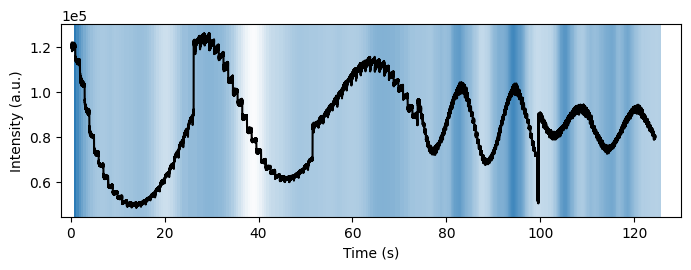

In [7]:
x_coor_all_clean, tau_clean = remove_outlier(x_coor_all, parameters_all[:,2], 0.95)
tau_smooth = smooth(tau_clean, 3)

x_FineStep, colors_all = Viz.make_fine_step(x_coor_all_clean, tau_smooth, step=2, color=color_blue, saturation=1, savgol_filter_level=(15, 3))
color_array = np.concatenate([np.expand_dims(x_FineStep, 1), colors_all], axis=1)

x_all_sample1 = np.copy(x_all)
y_all_sample1 = np.copy(y_all)
color_array_sample1 = np.copy(color_array)

fig, ax = plt.subplots(1, 1, figsize=(8, 2.5))
Viz.draw_background_colors(ax, color_array_sample1)
ax.plot(x_all_sample1, y_all_sample1, color='k')
Viz.set_labels(ax, xlabel='Time (s)', ylabel='Intensity (a.u.)', title=None, xlim=(-2, 130))
plt.show()

In [8]:
np.save('Assets/Saved_data/Sample1_fitting_results(sklearn).npy', np.concatenate([np.expand_dims(x_coor_all, 1), parameters_all], axis=1))
np.save('Assets/Saved_data/Sample1_bg_tau.npy', color_array_sample1)

### 4.2.2 Treated substrate (step width=0.11±0.01μm)

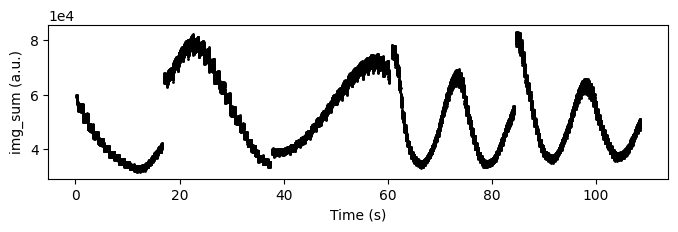

In [9]:
path = 'D:/datasets/RHEED_data/test7_gaussian_fit_parameters_all-04232023.h5'
D2_para = RHEED_parameter_dataset(path, camera_freq=500, sample_name='t0.16')

growth_list = ['growth_1', 'growth_2', 'growth_3', 'growth_4', 'growth_5']
D2_para.viz_RHEED_parameter_trend(growth_list, spot='spot_2', metric_list=['img_sum'], head_tail=(100,300), interval=200)

In [10]:
growth_dict = {'growth_1':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3}
x_all, y_all = D2_para.load_multiple_curves(growth_dict.keys(), spot, metric, x_start=0, interval=0)

parameters_all, x_coor_all, info = analyze_curves(D2_para, growth_dict, spot, metric, interval=0, fit_settings=fit_settings)
[xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info

# define two color regime
x_y1 = x_coor_all[losses_all[:,0]>losses_all[:,1]]
x_y2 = x_coor_all[losses_all[:,0]<losses_all[:,1]]
color_array = Viz.two_color_array(x_coor_all, x_y1, x_y2, bgc1, bgc2, transparency=0.5)
color_array = np.concatenate([np.expand_dims(x_coor_all, 1), color_array], axis=1)

#### (2). Fitted parameters

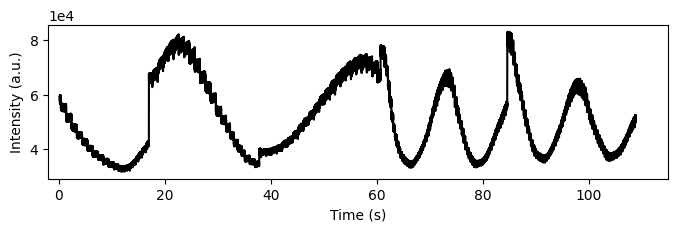

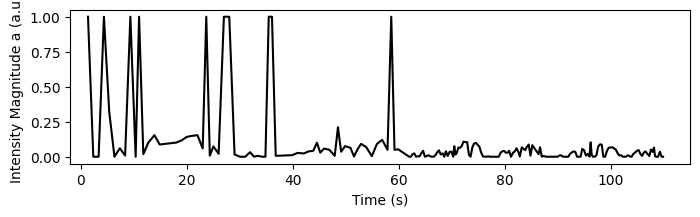

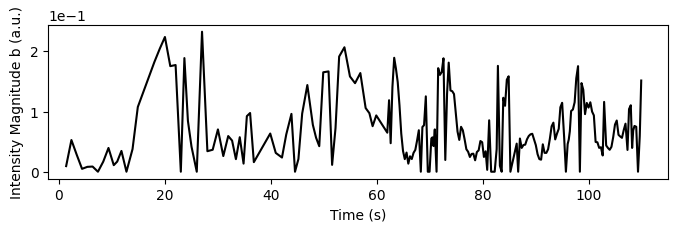

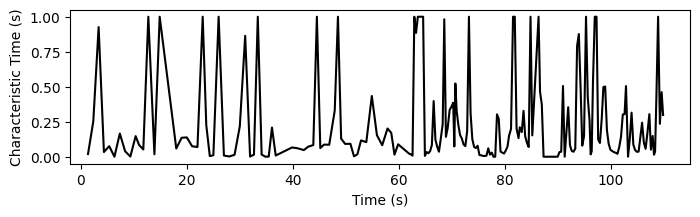

In [11]:
Viz.plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(8, 2), xlim=(-2, 115))
Viz.plot_curve(x_coor_all, parameters_all[:,0], plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude a (a.u.)', 
           yaxis_style='sci', figsize=(8, 2), xlim=(-2, 115))
Viz.plot_curve(x_coor_all, parameters_all[:,1], plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude b (a.u.)', 
           yaxis_style='sci', figsize=(8, 2), xlim=(-2, 115))
Viz.plot_curve(x_coor_all, parameters_all[:,2], plot_type='lineplot', xlabel='Time (s)', ylabel='Characteristic Time (s)', 
           yaxis_style='sci', figsize=(8, 2), xlim=(-2, 115))

#### (3). Because there is hard boundary when characteristic >= 1, so we can assume the characteristic data that >= 0.95 are outliers and remove from plot. And we also process the data with less noise to observe the trend.


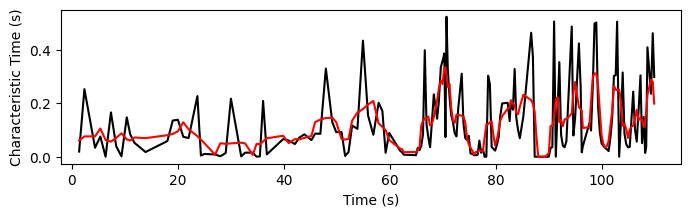

In [12]:
x_coor_all_clean, tau_clean = remove_outlier(x_coor_all, parameters_all[:,2], 0.95)
tau_smooth = smooth(tau_clean, 5)

x_coor_all_clean_sample2 = np.copy(x_coor_all_clean)
tau_clean_sample2 = np.copy(tau_clean)
tau_smooth_sample2 = np.copy(tau_smooth)

Viz.plot_curve(x_coor_all_clean_sample2, tau_clean_sample2, curve_y_fit=tau_smooth_sample2, plot_type='lineplot', 
           plot_colors=['k', 'r'], xlabel='Time (s)', ylabel='Characteristic Time (s)', 
           yaxis_style='linear', markersize=3, figsize=(8, 2), xlim=(-2, 115))

#### (4). Use the characteristic time as the background color intensity

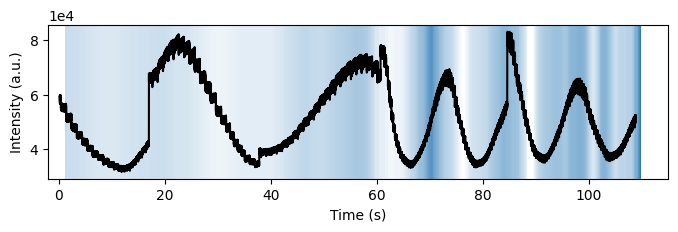

In [13]:
x_coor_all_clean, tau_clean = remove_outlier(x_coor_all, parameters_all[:,2], 0.95)
tau_smooth = smooth(tau_clean, 3)

x_FineStep, colors_all = Viz.make_fine_step(x_coor_all_clean, tau_smooth, step=2, color=color_blue, saturation=1, savgol_filter_level=(15, 3))
color_array = np.concatenate([np.expand_dims(x_FineStep, 1), colors_all], axis=1)

x_all_sample2 = np.copy(x_all)
y_all_sample2 = np.copy(y_all)
color_array_sample2 = np.copy(color_array)

fig, ax = plt.subplots(1, 1, figsize=(8, 2))
Viz.draw_background_colors(ax, color_array_sample2)
ax.plot(x_all_sample2, y_all_sample2, color='k')
Viz.set_labels(ax, xlabel='Time (s)', ylabel='Intensity (a.u.)', title=None, xlim=(-2, 115))
plt.show()

In [14]:
np.save('Assets/Saved_data/Sample2_fitting_results(sklearn).npy', np.concatenate([np.expand_dims(x_coor_all, 1), parameters_all], axis=1))
np.save('Assets/Saved_data/Sample2_bg_tau.npy', color_array_sample2)

### 4.2.3 Untreated substrate (step width=0.28±0.03μm)

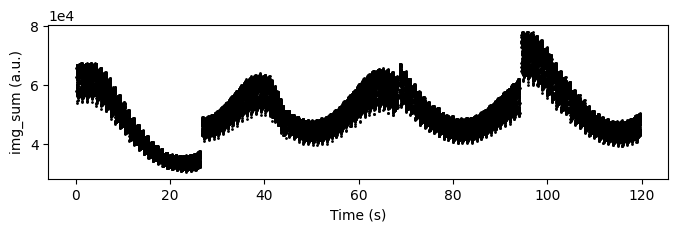

In [15]:
path = 'D:/datasets/RHEED_data/test9_gaussian_fit_parameters_all-04232023.h5'
D3_para = RHEED_parameter_dataset(path, camera_freq=500, sample_name='t0.16')

growth_list = ['growth_1', 'growth_2', 'growth_3', 'growth_4', 'growth_5']
D3_para.viz_RHEED_parameter_trend(growth_list, spot='spot_2', metric_list=['img_sum'], head_tail=(100,300), interval=200)

In [16]:
growth_dict = {'growth_1':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3}
x_all, y_all = D3_para.load_multiple_curves(growth_dict.keys(), spot, metric, x_start=0, interval=0)

parameters_all, x_coor_all, info = analyze_curves(D3_para, growth_dict, spot, metric, interval=0, fit_settings=fit_settings)
[xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info

# define two color regime
x_y1 = x_coor_all[losses_all[:,0]>losses_all[:,1]]
x_y2 = x_coor_all[losses_all[:,0]<losses_all[:,1]]
color_array = Viz.two_color_array(x_coor_all, x_y1, x_y2, bgc1, bgc2, transparency=0.5)
color_array = np.concatenate([np.expand_dims(x_coor_all, 1), color_array], axis=1)

#### (2). Fitted parameters

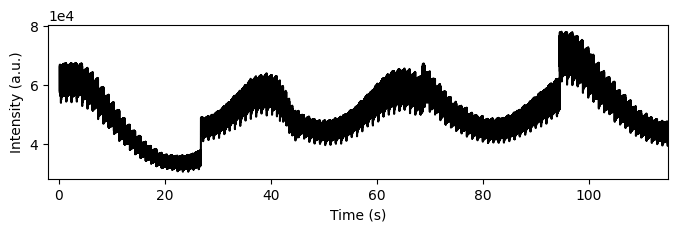

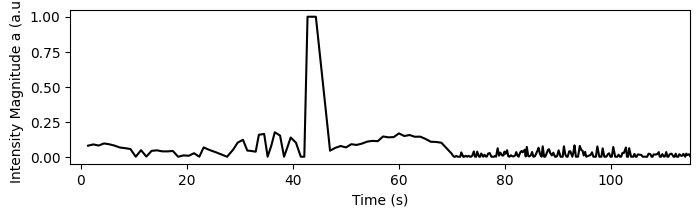

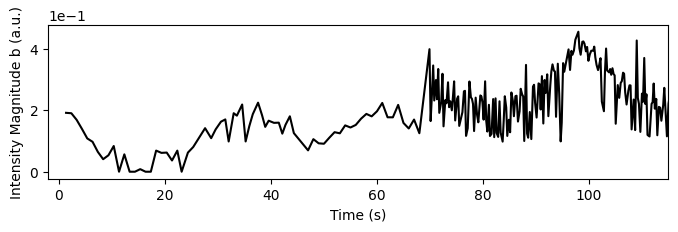

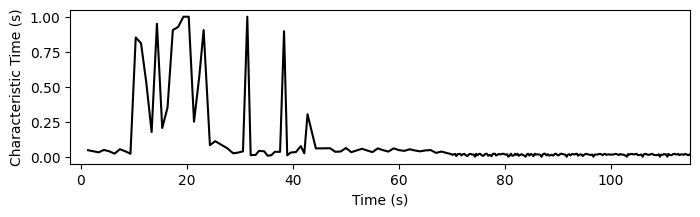

In [17]:
Viz.plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(8, 2), xlim=(-2, 115))
Viz.plot_curve(x_coor_all, parameters_all[:,0], plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude a (a.u.)', 
           yaxis_style='sci', figsize=(8, 2), xlim=(-2, 115))
Viz.plot_curve(x_coor_all, parameters_all[:,1], plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity Magnitude b (a.u.)', 
           yaxis_style='sci', figsize=(8, 2), xlim=(-2, 115))
Viz.plot_curve(x_coor_all, parameters_all[:,2], plot_type='lineplot', xlabel='Time (s)', ylabel='Characteristic Time (s)', 
           yaxis_style='sci', figsize=(8, 2), xlim=(-2, 115))

#### (3). Because there is hard boundary when characteristic >= 1, so we can assume the characteristic data that >= 0.95 are outliers and remove from plot. And we also process the data with less noise to observe the trend.


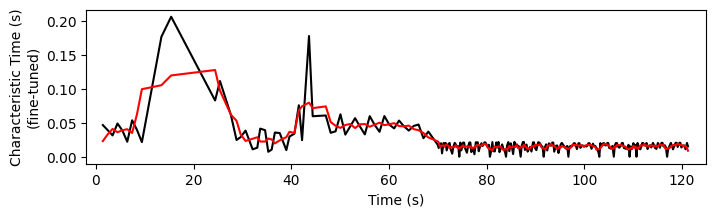

In [18]:
x_coor_all_clean, tau_clean = remove_outlier(x_coor_all, parameters_all[:,2], 0.95)
tau_smooth = smooth(tau_clean, 5)

x_coor_all_clean_sample3 = np.copy(x_coor_all_clean)
tau_clean_sample3 = np.copy(tau_clean)
tau_smooth_sample3 = np.copy(tau_smooth)
Viz.plot_curve(x_coor_all_clean_sample3, tau_clean_sample3, curve_y_fit=tau_smooth_sample3, plot_type='lineplot', 
           plot_colors=['k', 'r'], xlabel='Time (s)', ylabel='Characteristic Time (s)\n(fine-tuned)', 
           yaxis_style='linear', markersize=3, figsize=(8, 2), xlim=(-2, 125))

#### (4). Use the characteristic time as the background color intensity

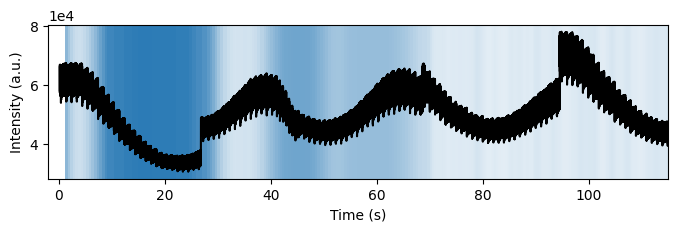

In [19]:
x_coor_all_clean, tau_clean = remove_outlier(x_coor_all, parameters_all[:,2], 0.95)
tau_smooth = smooth(tau_clean, 3)

x_FineStep, colors_all = Viz.make_fine_step(x_coor_all_clean, tau_smooth, step=2, color=color_blue, saturation=1, savgol_filter_level=(15, 3))
color_array = np.concatenate([np.expand_dims(x_FineStep, 1), colors_all], axis=1)

x_all_sample3 = np.copy(x_all)
y_all_sample3 = np.copy(y_all)
color_array_sample3 = np.copy(color_array)

fig, ax = plt.subplots(1, 1, figsize=(8, 2))
Viz.draw_background_colors(ax, color_array_sample3)
ax.plot(x_all_sample3, y_all_sample3, color='k')
Viz.set_labels(ax, xlabel='Time (s)', ylabel='Intensity (a.u.)', title=None, xlim=(-2, 115))
plt.show()

In [20]:
np.save('Assets/Saved_data/Sample3_fitting_results(sklearn).npy', np.concatenate([np.expand_dims(x_coor_all, 1), parameters_all], axis=1))
np.save('Assets/Saved_data/Sample3_bg_tau.npy', color_array_sample3)

## 3. Summary (skip fitting details above)

### 3.1 Plots of RHEED intensity and characteristic times

#### (1). Sample 1

In [21]:
x_all_sample1, y_all_sample1 = np.load('Assets/Saved_data/Sample1_x_all.npy'), np.load('Assets/Saved_data/Sample1_y_all.npy')
x_sklearn_sample1, tau_sklearn_sample1 = np.swapaxes(np.load('Assets/Saved_data/Sample1_fitting_results(sklearn).npy'), 0, 1)[[0, -1]]
x_sklearn_sample1, tau_clean_sample1 = remove_outlier(x_sklearn_sample1, tau_sklearn_sample1, 0.95)
tau_smooth_sample1 = smooth(tau_clean_sample1, 3)

bg_growth_sample1 = np.load('Assets/Saved_data/Sample1_bg_growth.npy')
bg_tau_sample1 = np.load('Assets/Saved_data/Sample1_bg_tau.npy')

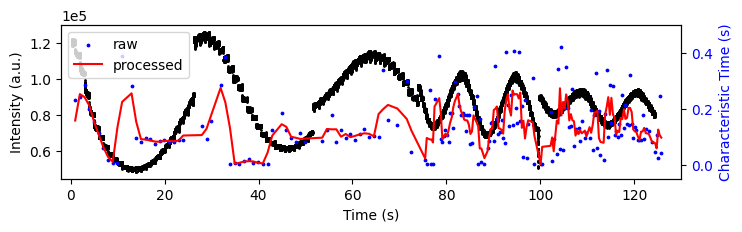

In [22]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 2))
ax1.scatter(x_all_sample1, y_all_sample1, color='k', s=1)
Viz.set_labels(ax1, xlabel='Time (s)', ylabel='Intensity (a.u.)', xlim=(-2, 130))

ax2 = ax1.twinx()
ax2.scatter(x_sklearn_sample1, tau_clean_sample1, color='b', s=3)
ax2.plot(x_sklearn_sample1, tau_smooth_sample1, color='r', markersize=3)
Viz.set_labels(ax2, ylabel='Characteristic Time (s)', yaxis_style='lineplot', ylim=(-0.05, 0.5))
ax2.tick_params(axis="y", color='k', labelcolor='b')
ax2.set_ylabel('Characteristic Time (s)', color='b')
plt.legend(['raw', 'processed'])
plt.savefig('Assets/Saved_data/4.sample1-no_bg.png')
plt.show()

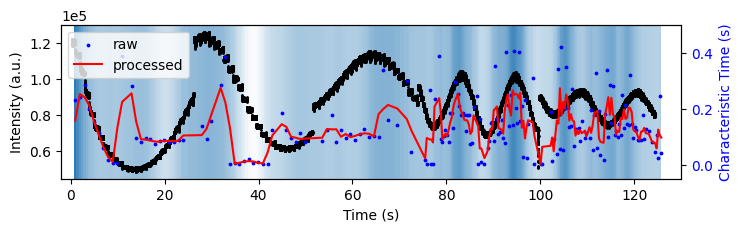

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 2))
Viz.draw_background_colors(ax1, bg_tau_sample1)
ax1.scatter(x_all_sample1, y_all_sample1, color='k', s=1)
Viz.set_labels(ax1, xlabel='Time (s)', ylabel='Intensity (a.u.)', xlim=(-2, 130))

ax2 = ax1.twinx()
ax2.scatter(x_sklearn_sample1, tau_clean_sample1, color='b', s=3)
ax2.plot(x_sklearn_sample1, tau_smooth_sample1, color='r', markersize=3)
Viz.set_labels(ax2, ylabel='Characteristic Time (s)', yaxis_style='lineplot', ylim=(-0.05, 0.5))
ax2.tick_params(axis="y", color='k', labelcolor='b')
ax2.set_ylabel('Characteristic Time (s)', color='b')
plt.legend(['raw', 'processed'])
plt.savefig('Assets/Saved_data/4.sample1-tau_bg.png')
plt.show()

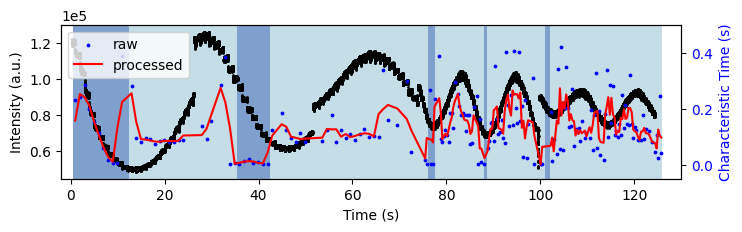

In [24]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 2))
Viz.draw_background_colors(ax1, bg_growth_sample1)
ax1.scatter(x_all_sample1, y_all_sample1, color='k', s=1)
Viz.set_labels(ax1, xlabel='Time (s)', ylabel='Intensity (a.u.)', xlim=(-2, 130))

ax2 = ax1.twinx()
ax2.scatter(x_sklearn_sample1, tau_clean_sample1, color='b', s=3)
ax2.plot(x_sklearn_sample1, tau_smooth_sample1, color='r', markersize=3)
Viz.set_labels(ax2, ylabel='Characteristic Time (s)', yaxis_style='lineplot', ylim=(-0.05, 0.5))
ax2.tick_params(axis="y", color='k', labelcolor='b')
ax2.set_ylabel('Characteristic Time (s)', color='b')
plt.legend(['raw', 'processed'])
plt.savefig('Assets/Saved_data/4.sample1-growth_bg.png')
plt.show()

#### (2). Sample 2

In [25]:
x_all_sample2, y_all_sample2 = np.load('Assets/Saved_data/Sample2_x_all.npy'), np.load('Assets/Saved_data/Sample2_y_all.npy')

x_sklearn_sample2, tau_sklearn_sample2 = np.swapaxes(np.load('Assets/Saved_data/Sample2_fitting_results(sklearn).npy'), 0, 1)[[0, -1]]
x_sklearn_sample2, tau_clean_sample2 = remove_outlier(x_sklearn_sample2, tau_sklearn_sample2, 0.95)
tau_smooth_sample2 = smooth(tau_clean_sample2, 3)

bg_growth_sample2 = np.load('Assets/Saved_data/Sample2_bg_growth.npy')
bg_tau_sample2 = np.load('Assets/Saved_data/Sample2_bg_tau.npy')

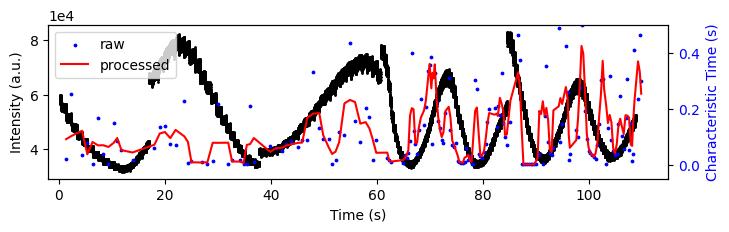

In [26]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 2))
ax1.scatter(x_all_sample2, y_all_sample2, color='k', s=1)
Viz.set_labels(ax1, xlabel='Time (s)', ylabel='Intensity (a.u.)', xlim=(-2, 115))

ax2 = ax1.twinx()
ax2.scatter(x_sklearn_sample2, tau_clean_sample2, color='b', s=3)
ax2.plot(x_sklearn_sample2, tau_smooth_sample2, color='r', markersize=3)
Viz.set_labels(ax2, ylabel='Characteristic Time (s)', yaxis_style='lineplot', ylim=(-0.05, 0.5))
ax2.tick_params(axis="y", color='k', labelcolor='b')
ax2.set_ylabel('Characteristic Time (s)', color='b')
plt.legend(['raw', 'processed'])
plt.savefig('Assets/Saved_data/4.sample2-no_bg.png')
plt.show()

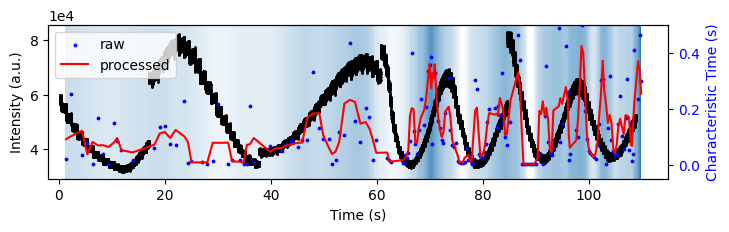

In [27]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 2))
Viz.draw_background_colors(ax1, bg_tau_sample2)
ax1.scatter(x_all_sample2, y_all_sample2, color='k', s=1)
Viz.set_labels(ax1, xlabel='Time (s)', ylabel='Intensity (a.u.)', xlim=(-2, 115))

ax2 = ax1.twinx()
ax2.scatter(x_sklearn_sample2, tau_clean_sample2, color='b', s=3)
ax2.plot(x_sklearn_sample2, tau_smooth_sample2, color='r', markersize=3)
Viz.set_labels(ax2, ylabel='Characteristic Time (s)', yaxis_style='lineplot', ylim=(-0.05, 0.5))
ax2.tick_params(axis="y", color='k', labelcolor='b')
ax2.set_ylabel('Characteristic Time (s)', color='b')
plt.legend(['raw', 'processed'])
plt.savefig('Assets/Saved_data/4.sample2-tau_bg.png')
plt.show()

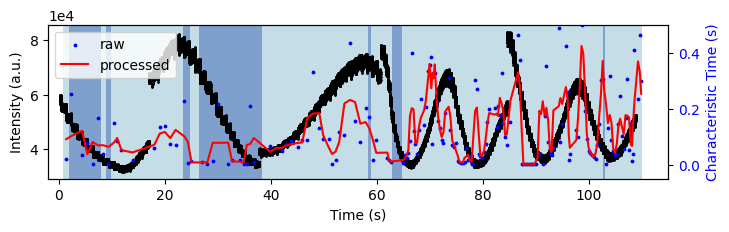

In [28]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 2))
Viz.draw_background_colors(ax1, bg_growth_sample2)
ax1.scatter(x_all_sample2, y_all_sample2, color='k', s=1)
Viz.set_labels(ax1, xlabel='Time (s)', ylabel='Intensity (a.u.)', xlim=(-2, 115))

ax2 = ax1.twinx()
ax2.scatter(x_sklearn_sample2, tau_clean_sample2, color='b', s=3)
ax2.plot(x_sklearn_sample2, tau_smooth_sample2, color='r', markersize=3)
Viz.set_labels(ax2, ylabel='Characteristic Time (s)', yaxis_style='lineplot', ylim=(-0.05, 0.5))
ax2.tick_params(axis="y", color='k', labelcolor='b')
ax2.set_ylabel('Characteristic Time (s)', color='b')
plt.legend(['raw', 'processed'])
plt.savefig('Assets/Saved_data/4.sample2-growth_bg.png')
plt.show()

#### (3). Sample 3

In [29]:
x_all_sample3, y_all_sample3 = np.load('Assets/Saved_data/Sample3_x_all.npy'), np.load('Assets/Saved_data/Sample3_y_all.npy')

x_sklearn_sample3, tau_sklearn_sample3 = np.swapaxes(np.load('Assets/Saved_data/Sample3_fitting_results(sklearn).npy'), 0, 1)[[0, -1]]
x_sklearn_sample3, tau_clean_sample3 = remove_outlier(x_sklearn_sample3, tau_sklearn_sample3, 0.95)
tau_smooth_sample3 = smooth(tau_clean_sample3, 3)

bg_growth_sample3 = np.load('Assets/Saved_data/Sample3_bg_growth.npy')
bg_tau_sample3 = np.load('Assets/Saved_data/Sample3_bg_tau.npy')

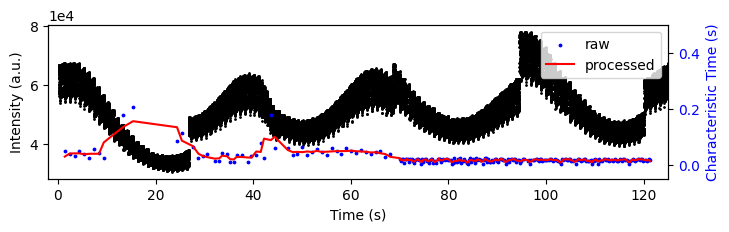

In [30]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 2))
ax1.scatter(x_all_sample3, y_all_sample3, color='k', s=1)
Viz.set_labels(ax1, xlabel='Time (s)', ylabel='Intensity (a.u.)', xlim=(-2, 125))

ax2 = ax1.twinx()
ax2.scatter(x_sklearn_sample3, tau_clean_sample3, color='b', s=3)
ax2.plot(x_sklearn_sample3, tau_smooth_sample3, color='r', markersize=3)
Viz.set_labels(ax2, ylabel='Characteristic Time (s)', yaxis_style='lineplot', ylim=(-0.05, 0.5))
ax2.tick_params(axis="y", color='k', labelcolor='b')
ax2.set_ylabel('Characteristic Time (s)', color='b')
plt.legend(['raw', 'processed'])
plt.savefig('Assets/Saved_data/4.sample3-no_bg.png')
plt.show()

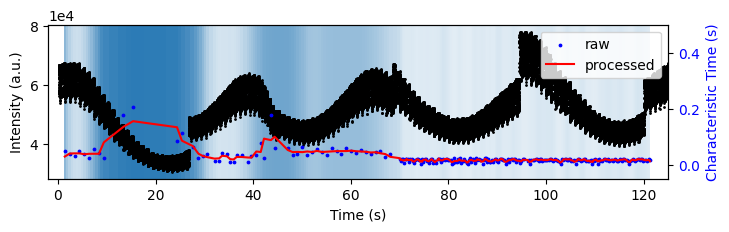

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 2))
Viz.draw_background_colors(ax1, bg_tau_sample3)
ax1.scatter(x_all_sample3, y_all_sample3, color='k', s=1)
Viz.set_labels(ax1, xlabel='Time (s)', ylabel='Intensity (a.u.)', xlim=(-2, 125))

ax2 = ax1.twinx()
ax2.scatter(x_sklearn_sample3, tau_clean_sample3, color='b', s=3)
ax2.plot(x_sklearn_sample3, tau_smooth_sample3, color='r', markersize=3)
Viz.set_labels(ax2, ylabel='Characteristic Time (s)', yaxis_style='lineplot', ylim=(-0.05, 0.5))
ax2.tick_params(axis="y", color='k', labelcolor='b')
ax2.set_ylabel('Characteristic Time (s)', color='b')
plt.legend(['raw', 'processed'])
plt.savefig('Assets/Saved_data/4.sample3-tau_bg.png')
plt.show()

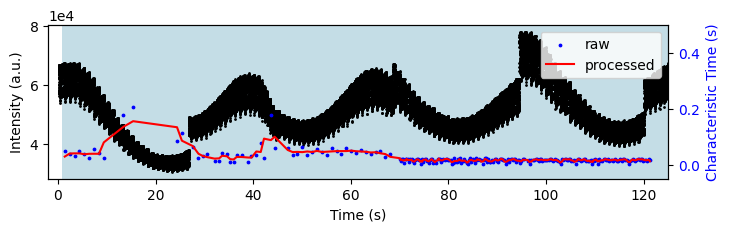

In [32]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 2))
Viz.draw_background_colors(ax1, bg_growth_sample3)
ax1.scatter(x_all_sample3, y_all_sample3, color='k', s=1)
Viz.set_labels(ax1, xlabel='Time (s)', ylabel='Intensity (a.u.)', xlim=(-2, 125))

ax2 = ax1.twinx()
ax2.scatter(x_sklearn_sample3, tau_clean_sample3, color='b', s=3)
ax2.plot(x_sklearn_sample3, tau_smooth_sample3, color='r', markersize=3)
Viz.set_labels(ax2, ylabel='Characteristic Time (s)', yaxis_style='lineplot', ylim=(-0.05, 0.5))
ax2.tick_params(axis="y", color='k', labelcolor='b')
ax2.set_ylabel('Characteristic Time (s)', color='b')
plt.legend(['raw', 'processed'])
plt.savefig('Assets/Saved_data/4.sample3-growth_bg.png')
plt.show()

### 3.2 Violinplot of three samples' characteristic time

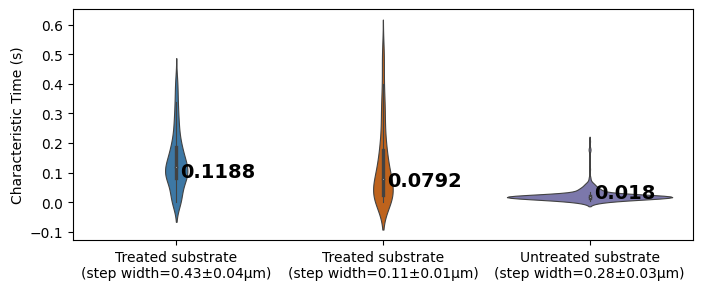

In [33]:
fig, ax = plt.subplots(figsize=(8, 3))
titles = ['Treated substrate\n(step width=0.43±0.04μm)',
          'Treated substrate\n(step width=0.11±0.01μm)',
          'Untreated substrate\n(step width=0.28±0.03μm)']
ax = sns.violinplot(data=[tau_clean_sample1, tau_clean_sample2, tau_clean_sample3], 
                    palette=[color_blue, color_orange, color_purple], linewidth=0.8)
ax.set_xticklabels(titles)

Viz.label_violinplot(ax, [tau_clean_sample1, tau_clean_sample2, tau_clean_sample3], label_type='average', text_pos='right')
ax.set_ylabel('Characteristic Time (s)')
plt.savefig('Assets/Saved_data/4.violinplot_plot(sklearn).svg', bbox_inches='tight', dpi=300)
plt.show()